<a href="https://colab.research.google.com/github/MahparaBadar/Deep-Learning/blob/main/Cat_Dog_Snake_Classifier_(DeepLearning_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
 65% 25.0M/38.4M [00:00<00:00, 55.6MB/s]
100% 38.4M/38.4M [00:00<00:00, 75.3MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/animal-image-classification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
# Import system libraries
import os
import itertools
from PIL import Image  # pillow

In [5]:
# Import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

print('modules loaded')

modules loaded


In [9]:
# Generate data paths with labels
train_data_dir = '/content/Animals'
filepaths = []
labels = []

In [10]:
folds = os.listdir(train_data_dir)
# print(folds)

In [11]:
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [12]:
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

In [13]:
train_df = pd.concat([Fseries, Lseries], axis=1)

In [16]:
# Load test data
test_data_dir = '/content/Animals'
filepaths = []
labels = []

In [17]:
folds = os.listdir(test_data_dir)
# print(folds)

In [18]:
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [19]:
# Concatenate test data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

In [20]:
test_df = pd.concat([Fseries, Lseries], axis=1)

In [21]:
# Split the test data into validation and test sets
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)

In [22]:
# Cropped image size and batch size
batch_size = 16
img_size = (224, 224)

In [23]:
# Create ImageDataGenerators for training, validation, and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [24]:
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


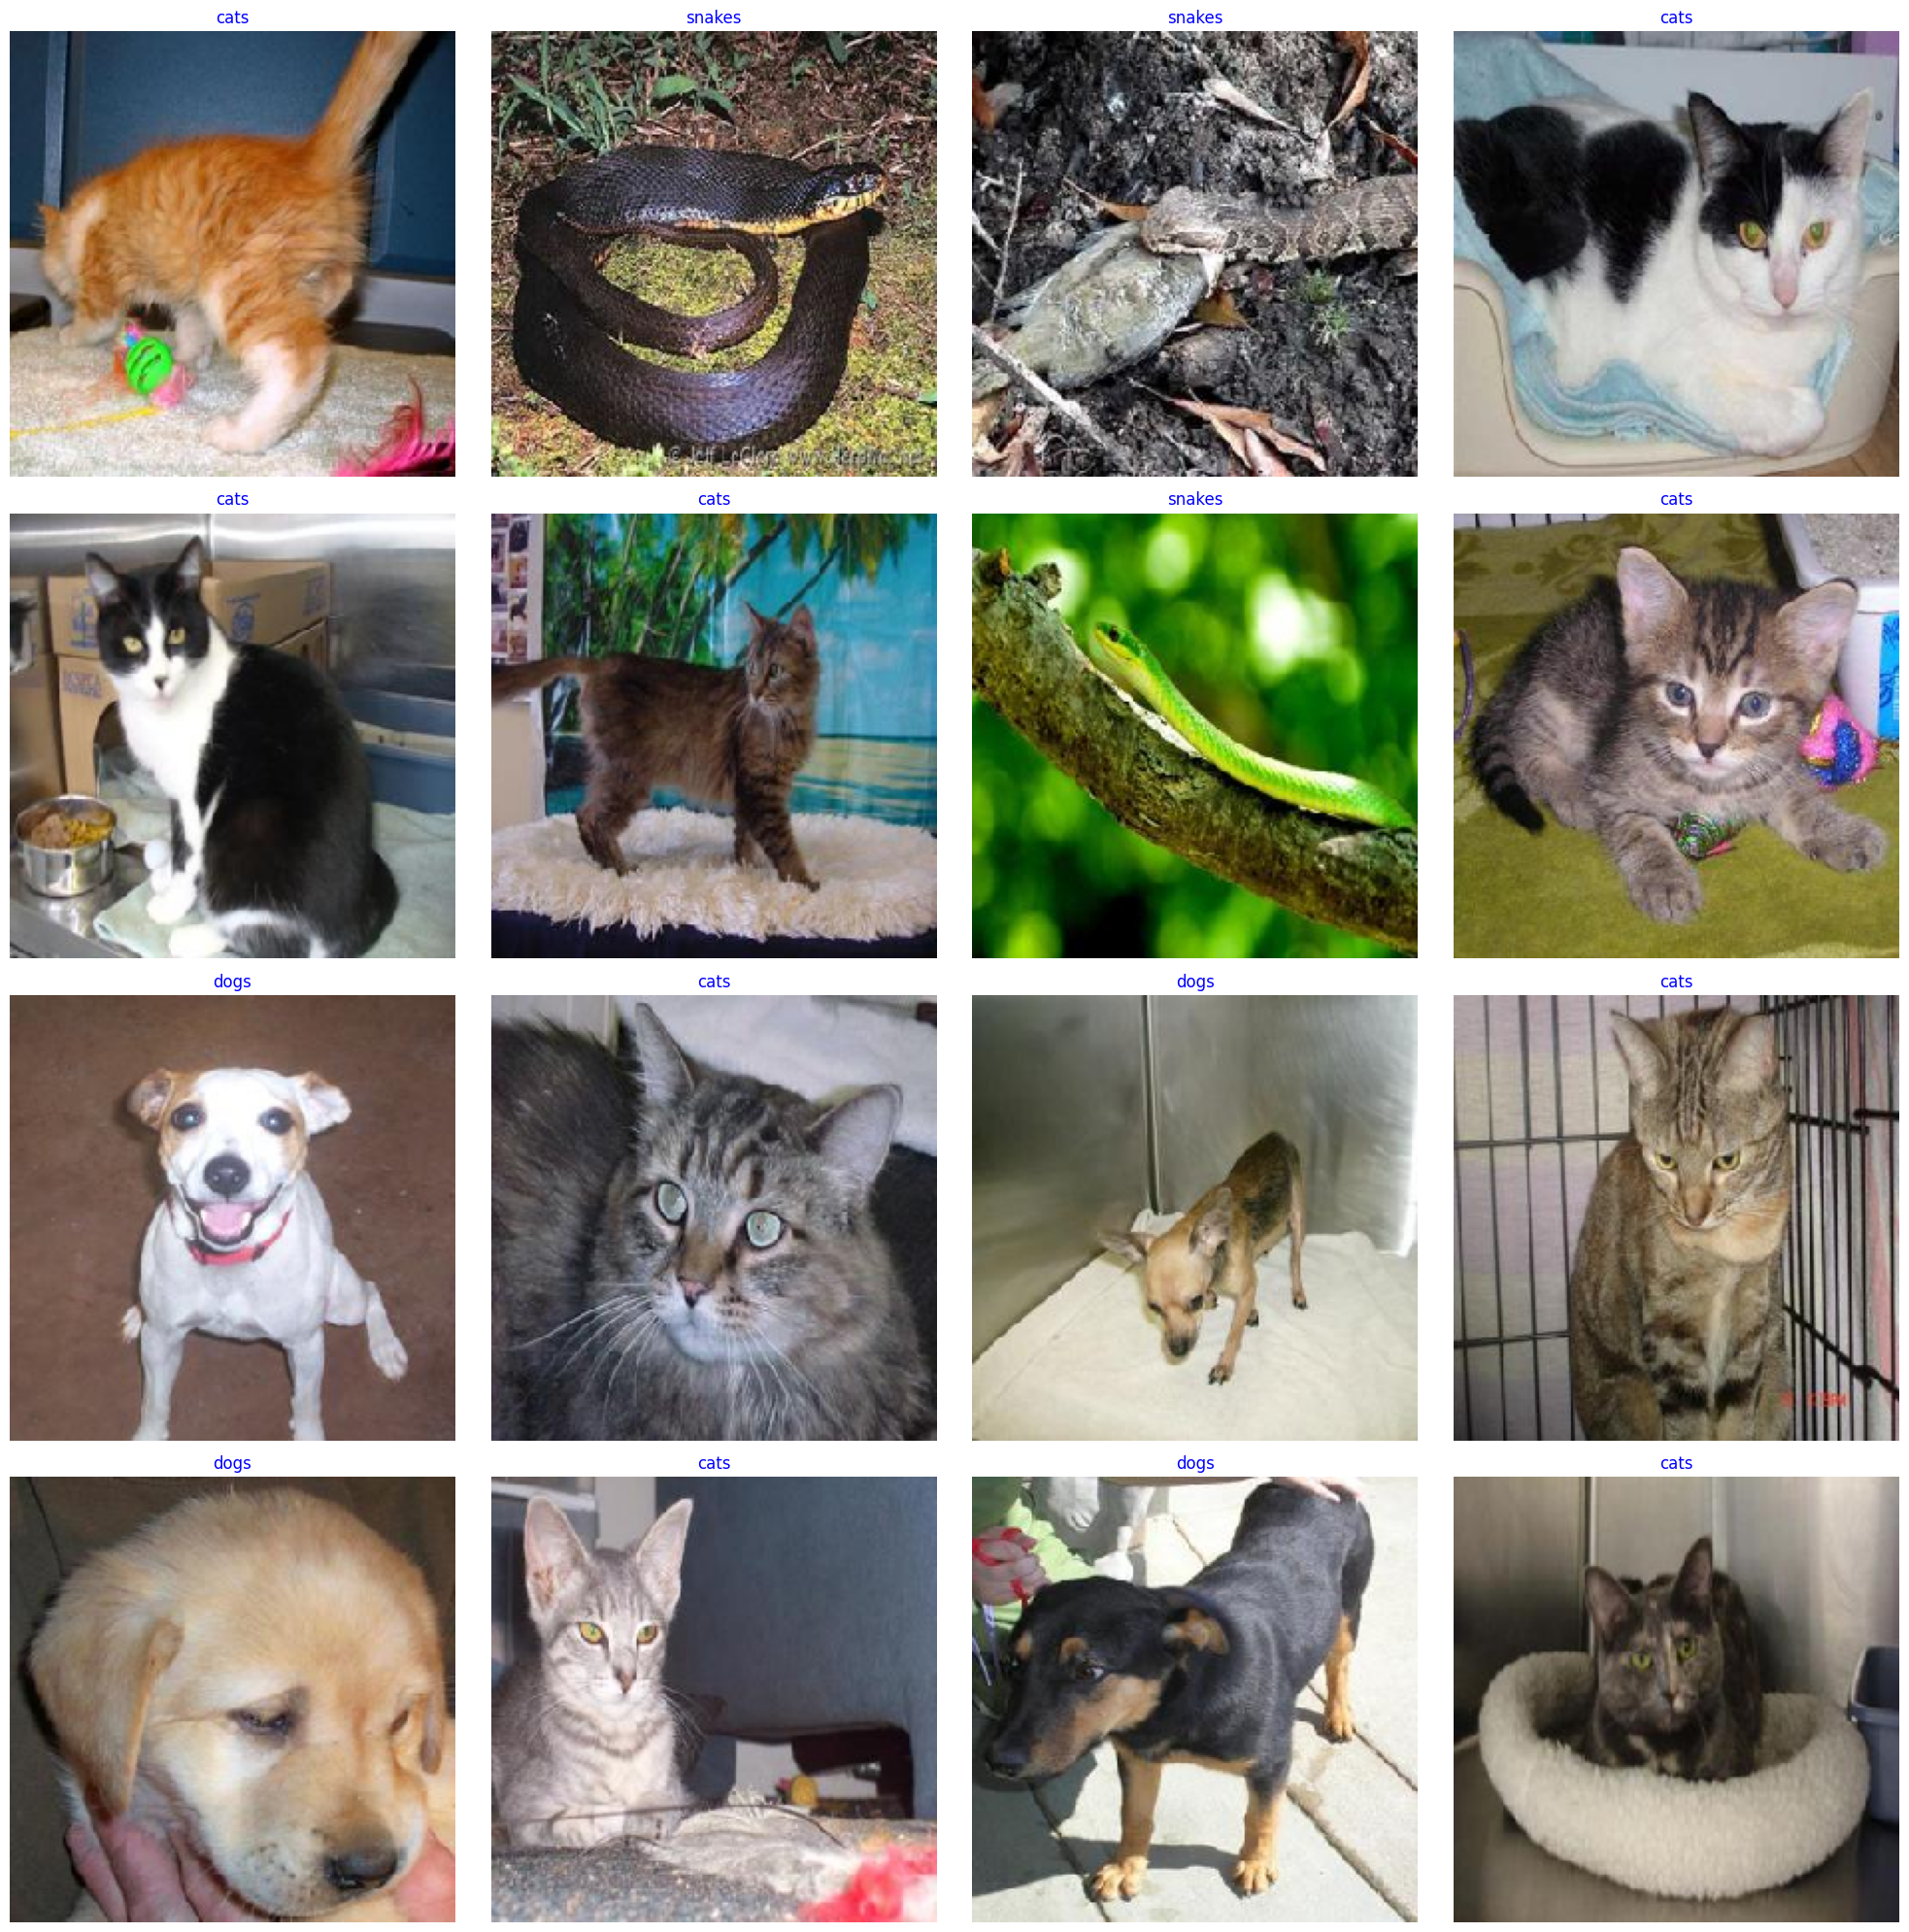

In [26]:
# Check the number of classes
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes)

# Display some images with labels
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

  plt.subplot(4, 4, i + 1)
  image = images[i] / 255  # scales data to range (0 - 255)
  plt.imshow(image)
  index = np.argmax(labels[i])  # get image index
  class_name = classes[index]  # get class of image
  plt.title(class_name, color='blue', fontsize=12)
  plt.axis('off')

plt.tight_layout()
plt.show()

**CNN Model**

In [27]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = keras.models.Sequential([
    keras.layers.Rescaling(1./255, input_shape=[224, 224, 3]),  # Normalization
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Ensure the output size matches the number of classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, shuffle=False)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.4650 - loss: 1.1542 - val_accuracy: 0.6200 - val_loss: 0.7923
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6264 - loss: 0.7769 - val_accuracy: 0.6673 - val_loss: 0.6900
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6836 - loss: 0.6986 - val_accuracy: 0.7920 - val_loss: 0.5207
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7583 - loss: 0.5676 - val_accuracy: 0.8507 - val_loss: 0.3788
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8090 - loss: 0.4656 - val_accuracy: 0.9067 - val_loss: 0.3274
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8471 - loss: 0.3765 - val_accuracy: 0.9493 - val_loss: 0.2259
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8852 - loss: 0.2937 - val_accuracy: 0.9727 - val_loss: 0.1233
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9275 - loss: 0.2034 - val_accuracy: 0.

In [29]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9825 - loss: 0.0562
Test Loss: 0.0551
Test Accuracy: 0.9840


In [32]:
 # Generate predictions
test_gen.reset()  # Reset the generator to ensure it starts from the beginning
predictions = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


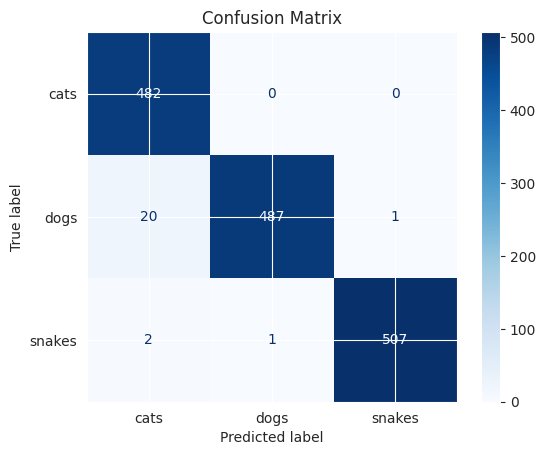

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        cats       0.96      1.00      0.98       482
        dogs       1.00      0.96      0.98       508
      snakes       1.00      0.99      1.00       510

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



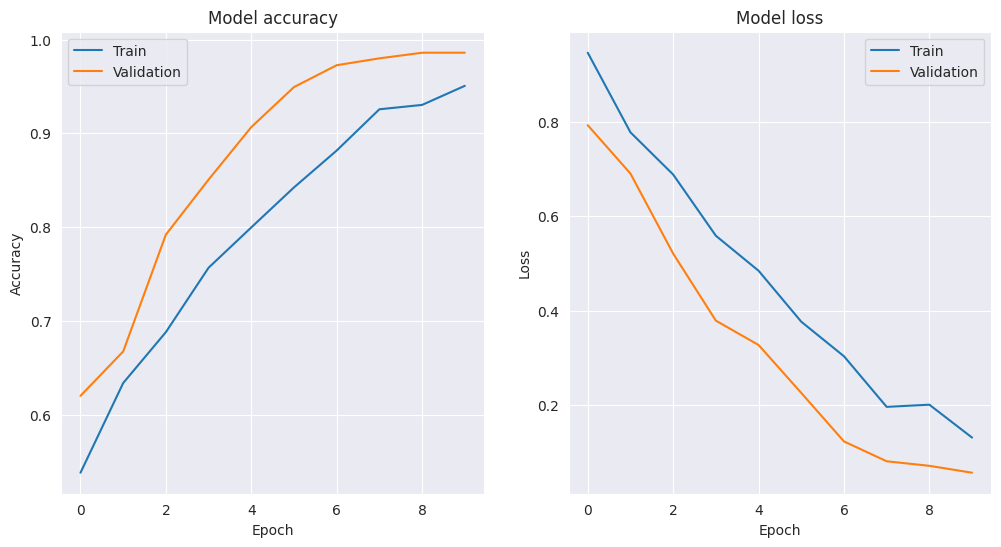

In [35]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

**ANN Model**

In [36]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [37]:
# Convert images to feature vectors
def preprocess_images(filepaths, img_size):
    images = []
    for filepath in filepaths:
        image = Image.open(filepath)
        image = image.resize(img_size)
        image = img_to_array(image)
        images.append(image)
    return np.array(images)

In [38]:
# Prepare training data
X_train = preprocess_images(train_df['filepaths'], img_size)
y_train = pd.get_dummies(train_df['labels']).values

In [39]:
# Prepare validation data
X_valid = preprocess_images(valid_df['filepaths'], img_size)
y_valid = pd.get_dummies(valid_df['labels']).values

In [40]:
# Prepare test data
X_test = preprocess_images(test_df['filepaths'], img_size)
y_test = pd.get_dummies(test_df['labels']).values

In [41]:
# Define ANN model
ann_model = keras.models.Sequential([
    Input(shape=(np.prod(img_size) * 3,)),  # Flattened image size
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(classes), activation='softmax')  # Output layer with softmax
])

In [42]:
# Compile the model
ann_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [43]:
# Train the model
history_ann = ann_model.fit(X_train.reshape(X_train.shape[0], -1), y_train,
                            epochs=10, batch_size=batch_size,
                            validation_data=(X_valid.reshape(X_valid.shape[0], -1), y_valid))

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.3376 - loss: 13022.0078 - val_accuracy: 0.3393 - val_loss: 249.6815
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.3896 - loss: 199.5827 - val_accuracy: 0.4600 - val_loss: 42.1287
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3895 - loss: 98.8049 - val_accuracy: 0.3567 - val_loss: 46.6877
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.4064 - loss: 33.8588 - val_accuracy: 0.3560 - val_loss: 47.0771
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3643 - loss: 31.8437 - val_accuracy: 0.3373 - val_loss: 1.1056
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3423 - loss: 1.2284 - val_accuracy: 0.3360 - val_loss: 1.0897
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3249 - loss: 1.0934 - val_accuracy: 0.3360 - val_loss: 1.0897
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3438 - loss:

In [44]:
# Evaluate the model
test_loss, test_accuracy = ann_model.evaluate(X_test.reshape(X_test.shape[0], -1), y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3321 - loss: 1.0970
Test loss: 1.0927692651748657
Test accuracy: 0.3440000116825104


In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

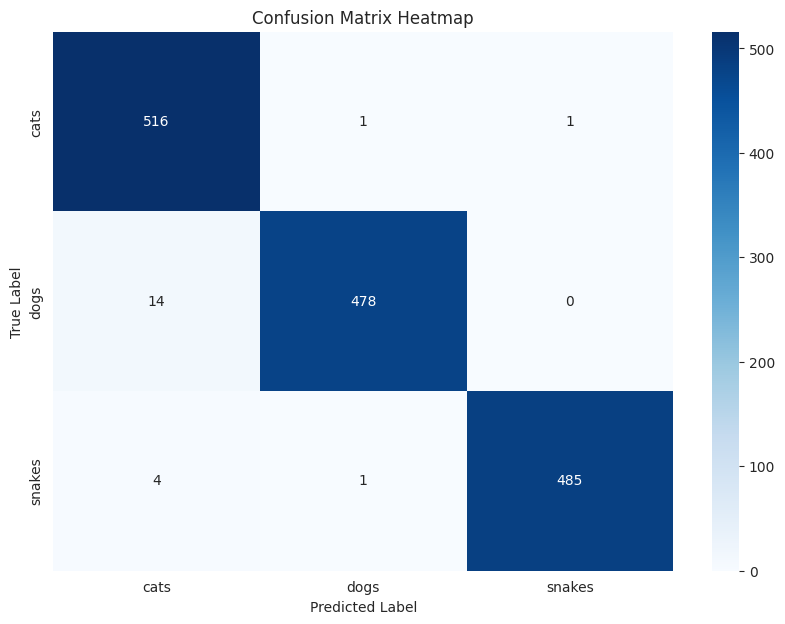

In [46]:
valid_labels = []
valid_predictions = []

for i in range(len(valid_gen)):
    images, labels = next(valid_gen)
    predictions = model.predict(images)

    valid_labels.extend(np.argmax(labels, axis=1))
    valid_predictions.extend(np.argmax(predictions, axis=1))

valid_labels = np.array(valid_labels)
valid_predictions = np.array(valid_predictions)

cm = confusion_matrix(valid_labels, valid_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

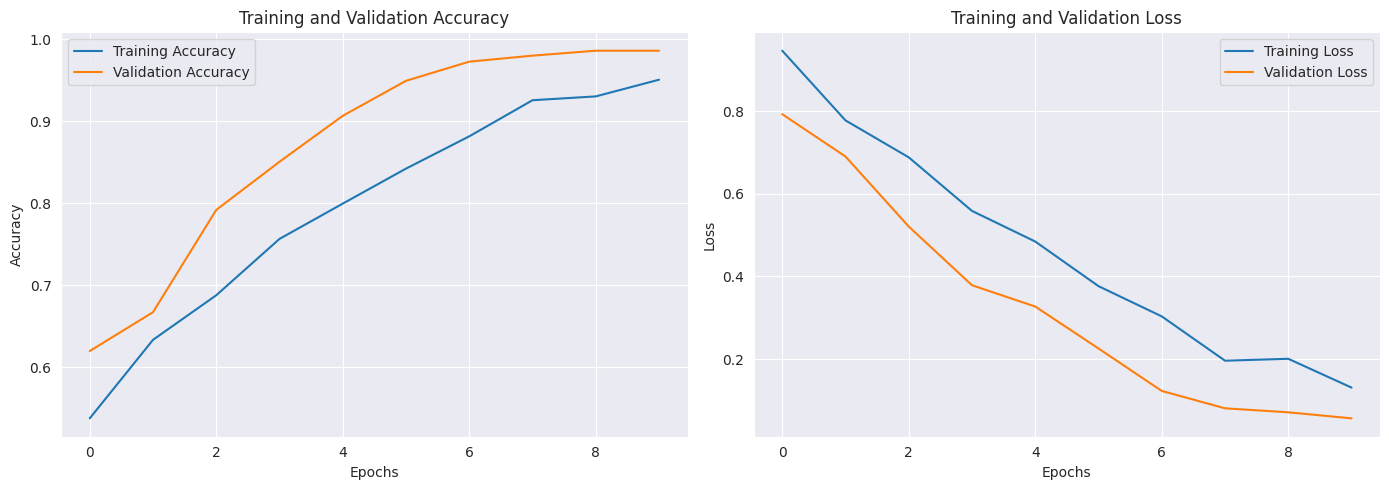

In [47]:
#accuarcay of training
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#accuarcay of loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
import cv2

In [49]:
test_img = cv2.imread('/content/cat_img.jpg')

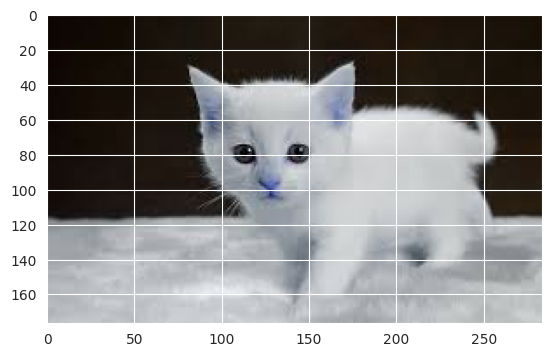

In [50]:
plt.imshow(test_img)

In [51]:
test_img.shape

(177, 284, 3)

In [52]:
test_img = cv2.resize(test_img,(224,224))

In [53]:
test_input = test_img.reshape((1,224,224,3))

In [54]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


array([[9.9914134e-01, 5.4586260e-04, 3.1279627e-04]], dtype=float32)

(218, 231, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.10711052, 0.01616094, 0.87672853]], dtype=float32)

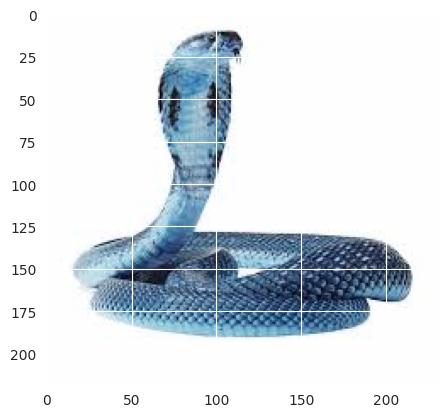

In [55]:
test_img = cv2.imread('/content/snake_img.jfif')
plt.imshow(test_img)
print(test_img.shape)
test_img = cv2.resize(test_img,(224,224))
test_input = test_img.reshape((1,224,224,3))
model.predict(test_input)

(183, 275, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[9.801451e-01, 1.985393e-02, 9.371796e-07]], dtype=float32)

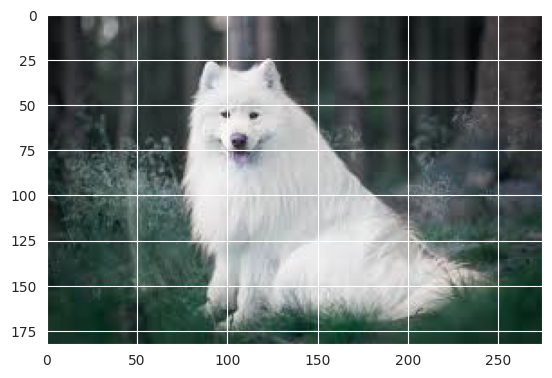

In [57]:
test_img = cv2.imread('/content/dog_img.jpg')
plt.imshow(test_img)
print(test_img.shape)
test_img = cv2.resize(test_img,(224,224))
test_input = test_img.reshape((1,224,224,3))
model.predict(test_input)